In [1]:
import copy
from functools import partial
import gc
from tensorflow import keras
from matplotlib import pyplot as plt
import numpy as np
from uncertainty_testbed.generators.data_generator_explicit import AnalyticBinaryClassGenerator
from uncertainty_testbed.utilities.functions import map_to_constant
from uncertainty_testbed.uncertainty_models.mc_dropout import MCDropoutLayer, MCDropoutKerasClassification

2022-05-07 20:45:47.314541: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-07 20:45:47.314686: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# generate some data
s = partial(map_to_constant, c=0.01)
eg = AnalyticBinaryClassGenerator(seed=42, num_inputs=10, name="gauss", threshold=0.5,
                                  noise_distribution="gauss", noise_scale=s)
x, y = eg.generate_labeled(120096)
x = x.astype("float32")
y = y.astype("uint8")
x_train, y_train = x[:33280, :], y[:33280]
x_val, y_val = x[100096:, :], y[100096:]

In [3]:
def opt_name(optimizer):
    return str(optimizer).split("object")[0].split(".")[-1].strip().lower()

optimizer_lookup = {
    opt_name(opt): opt for opt in  
    [keras.optimizers.Nadam(learning_rate=3e-5), 
     keras.optimizers.SGD(learning_rate=5e-3), 
     keras.optimizers.RMSprop(learning_rate=5e-3),
     keras.optimizers.Adam(learning_rate=3e-3),
     keras.optimizers.Adadelta(learning_rate=1e-1),
     keras.optimizers.Adamax(learning_rate=7e-3)]
}

optimal_schedules = [
    {
        "optimizer": keras.optimizers.Nadam(learning_rate=3e-5),
        "learning_rate": 3e-5,
        "batch": 256,
        "epoch": 3*28
    },
    {
        "optimizer": keras.optimizers.SGD(learning_rate=5e-3),
        "learning_rate": 5e-3,
        "batch": 256,
        "epoch": 3*59
    },
    {
        "optimizer": keras.optimizers.SGD(learning_rate=1e-2),
        "learning_rate" :1e-2,
        "batch": 8,
        "epoch": 3*1
    },
    {
        "optimizer": keras.optimizers.RMSprop(learning_rate=5e-3),
        "learning_rate": 5e-3,
        "batch": 8,
        "epoch": 3*1# 0.1781
    },
    {
        "optimizer": keras.optimizers.Adam(learning_rate=3e-3),
        "learning_rate": 3e-3,
        "batch": 8,
        "epoch": 3*1# 0.2076
    },
    {
        "optimizer": keras.optimizers.Adadelta(learning_rate=1e-1),
        "learning_rate": 1e-1,
        "batch": 8,
        "epoch": 3*2# 0.2354
    },
    {
        "optimizer": keras.optimizers.Adamax(learning_rate=7e-3),
        "learning_rate": 7e-3,
        "batch": 8,
        "epoch": 3*1# 0.2249
    },
    {
        "optimizer": keras.optimizers.Nadam(learning_rate=7e-3),
        "learning_rate": 7e-3,
        "batch": 8,
        "epoch": 3*4# 0.1905
    }
]

In [4]:
scan_results = []
champion_params = None
champion_loss = np.inf
for params in optimal_schedules:
    lr = params["learning_rate"]
    for learning_rate in [0.8*lr, lr, 1.2*lr]:
        optimizer = params["optimizer"]
        optimizer.learning_rate.assign(learning_rate)
        num_epochs = int(1.4*params["epoch"] + 2)
        batch_size = int(params["batch"])
        model = keras.Sequential()
        model.add(keras.layers.Dense(30, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(30, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(30, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(1, activation="sigmoid"))
        model.compile(
            optimizer=optimizer,
            loss="binary_crossentropy",
            metrics=["accuracy", "AUC"]
        )
        history = model.fit(
            x_train,
            y_train,
            epochs=num_epochs,
            batch_size=batch_size,
            validation_data=(x_val, y_val),
        )
        
        history_dict = history.history
        val_loss = history_dict["val_loss"]
        val_auc = history_dict["val_auc"]
        val_accuracy = history_dict["val_accuracy"]
        epochs = range(1, len(val_loss)+1)
        
        best_loss = {"loss": val_loss[np.argmin(val_loss)], "epoch": epochs[np.argmin(val_loss)]}
        best_auc = {"auc": val_auc[np.argmax(val_auc)], "epoch": epochs[np.argmax(val_auc)]}
        best_accuracy = {"accuracy": val_accuracy[np.argmax(val_accuracy)], "epoch": epochs[np.argmax(val_accuracy)]}
        
        ps = {k: copy.deepcopy(v) for k, v in params.items() if k not in ["optimizer", "model"]}
        ps["optimizer"] = opt_name(optimizer)
        ps["learning_rate"] = copy.deepcopy(learning_rate)
        ps["best_loss"] = best_loss
        ps["best_auc"] = best_auc
        ps["best_accuracy"] = best_accuracy
        print(ps)
        scan_results.append(ps)
        
        if best_loss["loss"] < champion_loss:
            champion_loss = best_loss["loss"]
            champion_params = {k: copy.deepcopy(v) for k, v in ps.items()}
            champion_params["model"] = keras.models.clone_model(model)
        

model = keras.models.clone_model(champion_params["model"])

Epoch 1/119


2022-05-07 20:45:52.533062: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-07 20:45:52.533117: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-07 20:45:52.533150: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (xps): /proc/driver/nvidia/version does not exist
2022-05-07 20:45:52.535053: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


130/130 [==============================] - 2s 5ms/step - loss: 0.7440 - accuracy: 0.4912 - auc: 0.4783 - val_loss: 0.7092 - val_accuracy: 0.5087 - val_auc: 0.4890
Epoch 2/119
130/130 [==============================] - 0s 3ms/step - loss: 0.7219 - accuracy: 0.5133 - auc: 0.5147 - val_loss: 0.6874 - val_accuracy: 0.5537 - val_auc: 0.5667
Epoch 3/119
130/130 [==============================] - 0s 3ms/step - loss: 0.7034 - accuracy: 0.5352 - auc: 0.5512 - val_loss: 0.6691 - val_accuracy: 0.6030 - val_auc: 0.6365
Epoch 4/119
130/130 [==============================] - 0s 3ms/step - loss: 0.6878 - accuracy: 0.5585 - auc: 0.5849 - val_loss: 0.6520 - val_accuracy: 0.6471 - val_auc: 0.6967
Epoch 5/119
130/130 [==============================] - 1s 4ms/step - loss: 0.6741 - accuracy: 0.5800 - auc: 0.6172 - val_loss: 0.6356 - val_accuracy: 0.6838 - val_auc: 0.7459
Epoch 6/119
130/130 [==============================] - 1s 5ms/step - loss: 0.6593 - accuracy: 0.6020 - auc: 0.6482 - val_loss: 0.6191 - v

Epoch 48/119
130/130 [==============================] - 1s 5ms/step - loss: 0.2220 - accuracy: 0.9078 - auc: 0.9702 - val_loss: 0.1204 - val_accuracy: 0.9624 - val_auc: 0.9954
Epoch 49/119
130/130 [==============================] - 1s 5ms/step - loss: 0.2221 - accuracy: 0.9042 - auc: 0.9700 - val_loss: 0.1178 - val_accuracy: 0.9632 - val_auc: 0.9956
Epoch 50/119
130/130 [==============================] - 1s 4ms/step - loss: 0.2177 - accuracy: 0.9100 - auc: 0.9713 - val_loss: 0.1153 - val_accuracy: 0.9643 - val_auc: 0.9958
Epoch 51/119
130/130 [==============================] - 1s 5ms/step - loss: 0.2104 - accuracy: 0.9118 - auc: 0.9733 - val_loss: 0.1127 - val_accuracy: 0.9646 - val_auc: 0.9960
Epoch 52/119
130/130 [==============================] - 1s 5ms/step - loss: 0.2108 - accuracy: 0.9125 - auc: 0.9730 - val_loss: 0.1105 - val_accuracy: 0.9657 - val_auc: 0.9962
Epoch 53/119
130/130 [==============================] - 1s 6ms/step - loss: 0.2079 - accuracy: 0.9144 - auc: 0.9737 - va

130/130 [==============================] - 1s 6ms/step - loss: 0.1312 - accuracy: 0.9460 - auc: 0.9895 - val_loss: 0.0589 - val_accuracy: 0.9844 - val_auc: 0.9992
Epoch 95/119
130/130 [==============================] - 1s 4ms/step - loss: 0.1283 - accuracy: 0.9471 - auc: 0.9898 - val_loss: 0.0581 - val_accuracy: 0.9847 - val_auc: 0.9992
Epoch 96/119
130/130 [==============================] - 1s 5ms/step - loss: 0.1264 - accuracy: 0.9482 - auc: 0.9902 - val_loss: 0.0574 - val_accuracy: 0.9848 - val_auc: 0.9992
Epoch 97/119
130/130 [==============================] - 1s 4ms/step - loss: 0.1245 - accuracy: 0.9494 - auc: 0.9904 - val_loss: 0.0567 - val_accuracy: 0.9851 - val_auc: 0.9992
Epoch 98/119
130/130 [==============================] - 1s 4ms/step - loss: 0.1245 - accuracy: 0.9489 - auc: 0.9905 - val_loss: 0.0561 - val_accuracy: 0.9855 - val_auc: 0.9993
Epoch 99/119
130/130 [==============================] - 1s 4ms/step - loss: 0.1258 - accuracy: 0.9493 - auc: 0.9902 - val_loss: 0.055

130/130 [==============================] - 0s 4ms/step - loss: 0.2881 - accuracy: 0.8828 - auc: 0.9524 - val_loss: 0.1874 - val_accuracy: 0.9384 - val_auc: 0.9881
Epoch 21/119
130/130 [==============================] - 1s 4ms/step - loss: 0.2752 - accuracy: 0.8881 - auc: 0.9567 - val_loss: 0.1786 - val_accuracy: 0.9412 - val_auc: 0.9891
Epoch 22/119
130/130 [==============================] - 1s 4ms/step - loss: 0.2671 - accuracy: 0.8895 - auc: 0.9589 - val_loss: 0.1708 - val_accuracy: 0.9442 - val_auc: 0.9900
Epoch 23/119
130/130 [==============================] - 1s 4ms/step - loss: 0.2669 - accuracy: 0.8891 - auc: 0.9582 - val_loss: 0.1639 - val_accuracy: 0.9466 - val_auc: 0.9908
Epoch 24/119
130/130 [==============================] - 1s 4ms/step - loss: 0.2547 - accuracy: 0.8948 - auc: 0.9623 - val_loss: 0.1574 - val_accuracy: 0.9488 - val_auc: 0.9914
Epoch 25/119
130/130 [==============================] - 1s 4ms/step - loss: 0.2475 - accuracy: 0.8984 - auc: 0.9642 - val_loss: 0.151

130/130 [==============================] - 1s 4ms/step - loss: 0.1240 - accuracy: 0.9508 - auc: 0.9904 - val_loss: 0.0583 - val_accuracy: 0.9821 - val_auc: 0.9989
Epoch 67/119
130/130 [==============================] - 1s 4ms/step - loss: 0.1241 - accuracy: 0.9493 - auc: 0.9905 - val_loss: 0.0575 - val_accuracy: 0.9822 - val_auc: 0.9990
Epoch 68/119
130/130 [==============================] - 1s 4ms/step - loss: 0.1202 - accuracy: 0.9516 - auc: 0.9911 - val_loss: 0.0565 - val_accuracy: 0.9824 - val_auc: 0.9990
Epoch 69/119
130/130 [==============================] - 1s 4ms/step - loss: 0.1166 - accuracy: 0.9532 - auc: 0.9917 - val_loss: 0.0556 - val_accuracy: 0.9823 - val_auc: 0.9991
Epoch 70/119
130/130 [==============================] - 1s 4ms/step - loss: 0.1149 - accuracy: 0.9539 - auc: 0.9918 - val_loss: 0.0547 - val_accuracy: 0.9825 - val_auc: 0.9991
Epoch 71/119
130/130 [==============================] - 1s 4ms/step - loss: 0.1167 - accuracy: 0.9529 - auc: 0.9917 - val_loss: 0.053

130/130 [==============================] - 1s 4ms/step - loss: 0.0734 - accuracy: 0.9703 - auc: 0.9966 - val_loss: 0.0309 - val_accuracy: 0.9911 - val_auc: 0.9998
Epoch 113/119
130/130 [==============================] - 1s 4ms/step - loss: 0.0709 - accuracy: 0.9718 - auc: 0.9968 - val_loss: 0.0304 - val_accuracy: 0.9919 - val_auc: 0.9998
Epoch 114/119
130/130 [==============================] - 1s 4ms/step - loss: 0.0722 - accuracy: 0.9709 - auc: 0.9967 - val_loss: 0.0301 - val_accuracy: 0.9919 - val_auc: 0.9998
Epoch 115/119
130/130 [==============================] - 1s 4ms/step - loss: 0.0688 - accuracy: 0.9729 - auc: 0.9971 - val_loss: 0.0298 - val_accuracy: 0.9920 - val_auc: 0.9998
Epoch 116/119
130/130 [==============================] - 1s 4ms/step - loss: 0.0703 - accuracy: 0.9706 - auc: 0.9969 - val_loss: 0.0294 - val_accuracy: 0.9920 - val_auc: 0.9998
Epoch 117/119
130/130 [==============================] - 1s 4ms/step - loss: 0.0668 - accuracy: 0.9735 - auc: 0.9973 - val_loss: 

130/130 [==============================] - 1s 5ms/step - loss: 0.1459 - accuracy: 0.9401 - auc: 0.9871 - val_loss: 0.0672 - val_accuracy: 0.9833 - val_auc: 0.9990
Epoch 39/119
130/130 [==============================] - 1s 4ms/step - loss: 0.1450 - accuracy: 0.9401 - auc: 0.9872 - val_loss: 0.0657 - val_accuracy: 0.9837 - val_auc: 0.9990
Epoch 40/119
130/130 [==============================] - 0s 4ms/step - loss: 0.1442 - accuracy: 0.9406 - auc: 0.9873 - val_loss: 0.0643 - val_accuracy: 0.9844 - val_auc: 0.9991
Epoch 41/119
130/130 [==============================] - 1s 4ms/step - loss: 0.1411 - accuracy: 0.9428 - auc: 0.9879 - val_loss: 0.0629 - val_accuracy: 0.9849 - val_auc: 0.9992
Epoch 42/119
130/130 [==============================] - 1s 4ms/step - loss: 0.1341 - accuracy: 0.9460 - auc: 0.9891 - val_loss: 0.0615 - val_accuracy: 0.9855 - val_auc: 0.9992
Epoch 43/119
130/130 [==============================] - 1s 4ms/step - loss: 0.1359 - accuracy: 0.9442 - auc: 0.9887 - val_loss: 0.060

130/130 [==============================] - 0s 4ms/step - loss: 0.0758 - accuracy: 0.9688 - auc: 0.9965 - val_loss: 0.0301 - val_accuracy: 0.9935 - val_auc: 0.9999
Epoch 85/119
130/130 [==============================] - 1s 4ms/step - loss: 0.0742 - accuracy: 0.9700 - auc: 0.9966 - val_loss: 0.0298 - val_accuracy: 0.9937 - val_auc: 0.9999
Epoch 86/119
130/130 [==============================] - 1s 4ms/step - loss: 0.0753 - accuracy: 0.9691 - auc: 0.9965 - val_loss: 0.0294 - val_accuracy: 0.9936 - val_auc: 0.9999
Epoch 87/119
130/130 [==============================] - 1s 4ms/step - loss: 0.0727 - accuracy: 0.9703 - auc: 0.9968 - val_loss: 0.0290 - val_accuracy: 0.9937 - val_auc: 0.9999
Epoch 88/119
130/130 [==============================] - 1s 4ms/step - loss: 0.0714 - accuracy: 0.9705 - auc: 0.9969 - val_loss: 0.0286 - val_accuracy: 0.9938 - val_auc: 0.9999
Epoch 89/119
130/130 [==============================] - 1s 4ms/step - loss: 0.0683 - accuracy: 0.9730 - auc: 0.9971 - val_loss: 0.028

130/130 [==============================] - 0s 4ms/step - loss: 0.6287 - accuracy: 0.6678 - auc: 0.7259 - val_loss: 0.5911 - val_accuracy: 0.7897 - val_auc: 0.8660
Epoch 11/249
130/130 [==============================] - 0s 4ms/step - loss: 0.6125 - accuracy: 0.6873 - auc: 0.7524 - val_loss: 0.5680 - val_accuracy: 0.8102 - val_auc: 0.8884
Epoch 12/249
130/130 [==============================] - 0s 4ms/step - loss: 0.5947 - accuracy: 0.7066 - auc: 0.7756 - val_loss: 0.5408 - val_accuracy: 0.8290 - val_auc: 0.9081
Epoch 13/249
130/130 [==============================] - 0s 4ms/step - loss: 0.5731 - accuracy: 0.7254 - auc: 0.8000 - val_loss: 0.5097 - val_accuracy: 0.8457 - val_auc: 0.9256
Epoch 14/249
130/130 [==============================] - 0s 4ms/step - loss: 0.5479 - accuracy: 0.7477 - auc: 0.8240 - val_loss: 0.4752 - val_accuracy: 0.8643 - val_auc: 0.9408
Epoch 15/249
130/130 [==============================] - 0s 4ms/step - loss: 0.5225 - accuracy: 0.7631 - auc: 0.8433 - val_loss: 0.438

130/130 [==============================] - 1s 4ms/step - loss: 0.1064 - accuracy: 0.9592 - auc: 0.9934 - val_loss: 0.0399 - val_accuracy: 0.9923 - val_auc: 0.9998
Epoch 57/249
130/130 [==============================] - 0s 4ms/step - loss: 0.1023 - accuracy: 0.9630 - auc: 0.9940 - val_loss: 0.0389 - val_accuracy: 0.9924 - val_auc: 0.9998
Epoch 58/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0988 - accuracy: 0.9632 - auc: 0.9945 - val_loss: 0.0380 - val_accuracy: 0.9923 - val_auc: 0.9998
Epoch 59/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0968 - accuracy: 0.9645 - auc: 0.9946 - val_loss: 0.0371 - val_accuracy: 0.9926 - val_auc: 0.9998
Epoch 60/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0972 - accuracy: 0.9640 - auc: 0.9945 - val_loss: 0.0363 - val_accuracy: 0.9927 - val_auc: 0.9998
Epoch 61/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0936 - accuracy: 0.9644 - auc: 0.9950 - val_loss: 0.035

130/130 [==============================] - 0s 4ms/step - loss: 0.0560 - accuracy: 0.9804 - auc: 0.9982 - val_loss: 0.0207 - val_accuracy: 0.9952 - val_auc: 0.9999
Epoch 103/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0544 - accuracy: 0.9801 - auc: 0.9984 - val_loss: 0.0205 - val_accuracy: 0.9954 - val_auc: 0.9999
Epoch 104/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0548 - accuracy: 0.9798 - auc: 0.9983 - val_loss: 0.0203 - val_accuracy: 0.9952 - val_auc: 0.9999
Epoch 105/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0519 - accuracy: 0.9812 - auc: 0.9985 - val_loss: 0.0201 - val_accuracy: 0.9952 - val_auc: 0.9999
Epoch 106/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0524 - accuracy: 0.9813 - auc: 0.9985 - val_loss: 0.0200 - val_accuracy: 0.9952 - val_auc: 0.9999
Epoch 107/249
130/130 [==============================] - 0s 3ms/step - loss: 0.0516 - accuracy: 0.9816 - auc: 0.9985 - val_loss: 

130/130 [==============================] - 0s 4ms/step - loss: 0.0371 - accuracy: 0.9869 - auc: 0.9993 - val_loss: 0.0145 - val_accuracy: 0.9965 - val_auc: 1.0000
Epoch 149/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0375 - accuracy: 0.9871 - auc: 0.9992 - val_loss: 0.0143 - val_accuracy: 0.9967 - val_auc: 1.0000
Epoch 150/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0373 - accuracy: 0.9868 - auc: 0.9992 - val_loss: 0.0143 - val_accuracy: 0.9966 - val_auc: 1.0000
Epoch 151/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0355 - accuracy: 0.9876 - auc: 0.9993 - val_loss: 0.0142 - val_accuracy: 0.9966 - val_auc: 1.0000
Epoch 152/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0376 - accuracy: 0.9861 - auc: 0.9992 - val_loss: 0.0141 - val_accuracy: 0.9967 - val_auc: 1.0000
Epoch 153/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0369 - accuracy: 0.9864 - auc: 0.9992 - val_loss: 

130/130 [==============================] - 0s 4ms/step - loss: 0.0273 - accuracy: 0.9907 - auc: 0.9996 - val_loss: 0.0112 - val_accuracy: 0.9976 - val_auc: 1.0000
Epoch 195/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0265 - accuracy: 0.9912 - auc: 0.9996 - val_loss: 0.0111 - val_accuracy: 0.9977 - val_auc: 1.0000
Epoch 196/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0277 - accuracy: 0.9904 - auc: 0.9996 - val_loss: 0.0110 - val_accuracy: 0.9976 - val_auc: 1.0000
Epoch 197/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0267 - accuracy: 0.9904 - auc: 0.9996 - val_loss: 0.0110 - val_accuracy: 0.9973 - val_auc: 1.0000
Epoch 198/249
130/130 [==============================] - 1s 4ms/step - loss: 0.0254 - accuracy: 0.9918 - auc: 0.9997 - val_loss: 0.0109 - val_accuracy: 0.9973 - val_auc: 1.0000
Epoch 199/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0244 - accuracy: 0.9917 - auc: 0.9997 - val_loss: 

130/130 [==============================] - 0s 4ms/step - loss: 0.0215 - accuracy: 0.9923 - auc: 0.9998 - val_loss: 0.0090 - val_accuracy: 0.9979 - val_auc: 1.0000
Epoch 241/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0210 - accuracy: 0.9925 - auc: 0.9998 - val_loss: 0.0091 - val_accuracy: 0.9979 - val_auc: 1.0000
Epoch 242/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0215 - accuracy: 0.9926 - auc: 0.9998 - val_loss: 0.0092 - val_accuracy: 0.9977 - val_auc: 1.0000
Epoch 243/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0209 - accuracy: 0.9927 - auc: 0.9998 - val_loss: 0.0092 - val_accuracy: 0.9976 - val_auc: 1.0000
Epoch 244/249
130/130 [==============================] - 1s 4ms/step - loss: 0.0215 - accuracy: 0.9930 - auc: 0.9998 - val_loss: 0.0091 - val_accuracy: 0.9976 - val_auc: 1.0000
Epoch 245/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0210 - accuracy: 0.9931 - auc: 0.9997 - val_loss: 

130/130 [==============================] - 0s 3ms/step - loss: 0.1382 - accuracy: 0.9447 - auc: 0.9891 - val_loss: 0.0585 - val_accuracy: 0.9877 - val_auc: 0.9994
Epoch 37/249
130/130 [==============================] - 0s 3ms/step - loss: 0.1315 - accuracy: 0.9484 - auc: 0.9903 - val_loss: 0.0560 - val_accuracy: 0.9879 - val_auc: 0.9995
Epoch 38/249
130/130 [==============================] - 0s 3ms/step - loss: 0.1294 - accuracy: 0.9496 - auc: 0.9904 - val_loss: 0.0537 - val_accuracy: 0.9887 - val_auc: 0.9995
Epoch 39/249
130/130 [==============================] - 0s 3ms/step - loss: 0.1232 - accuracy: 0.9538 - auc: 0.9915 - val_loss: 0.0514 - val_accuracy: 0.9898 - val_auc: 0.9996
Epoch 40/249
130/130 [==============================] - 0s 3ms/step - loss: 0.1197 - accuracy: 0.9529 - auc: 0.9919 - val_loss: 0.0493 - val_accuracy: 0.9902 - val_auc: 0.9996
Epoch 41/249
130/130 [==============================] - 0s 4ms/step - loss: 0.1165 - accuracy: 0.9555 - auc: 0.9923 - val_loss: 0.047

130/130 [==============================] - 0s 4ms/step - loss: 0.0537 - accuracy: 0.9802 - auc: 0.9984 - val_loss: 0.0205 - val_accuracy: 0.9955 - val_auc: 0.9999
Epoch 83/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0527 - accuracy: 0.9813 - auc: 0.9985 - val_loss: 0.0203 - val_accuracy: 0.9956 - val_auc: 0.9999
Epoch 84/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0531 - accuracy: 0.9811 - auc: 0.9985 - val_loss: 0.0201 - val_accuracy: 0.9955 - val_auc: 0.9999
Epoch 85/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0520 - accuracy: 0.9807 - auc: 0.9985 - val_loss: 0.0198 - val_accuracy: 0.9960 - val_auc: 0.9999
Epoch 86/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0510 - accuracy: 0.9811 - auc: 0.9986 - val_loss: 0.0197 - val_accuracy: 0.9960 - val_auc: 0.9999
Epoch 87/249
130/130 [==============================] - 1s 4ms/step - loss: 0.0494 - accuracy: 0.9822 - auc: 0.9987 - val_loss: 0.019

130/130 [==============================] - 0s 4ms/step - loss: 0.0337 - accuracy: 0.9875 - auc: 0.9994 - val_loss: 0.0132 - val_accuracy: 0.9973 - val_auc: 1.0000
Epoch 129/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0337 - accuracy: 0.9876 - auc: 0.9994 - val_loss: 0.0131 - val_accuracy: 0.9972 - val_auc: 1.0000
Epoch 130/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0325 - accuracy: 0.9886 - auc: 0.9995 - val_loss: 0.0130 - val_accuracy: 0.9973 - val_auc: 1.0000
Epoch 131/249
130/130 [==============================] - 1s 4ms/step - loss: 0.0326 - accuracy: 0.9888 - auc: 0.9994 - val_loss: 0.0128 - val_accuracy: 0.9973 - val_auc: 1.0000
Epoch 132/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0315 - accuracy: 0.9893 - auc: 0.9995 - val_loss: 0.0127 - val_accuracy: 0.9972 - val_auc: 1.0000
Epoch 133/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0327 - accuracy: 0.9886 - auc: 0.9994 - val_loss: 

130/130 [==============================] - 0s 4ms/step - loss: 0.0248 - accuracy: 0.9913 - auc: 0.9997 - val_loss: 0.0100 - val_accuracy: 0.9977 - val_auc: 1.0000
Epoch 175/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0247 - accuracy: 0.9910 - auc: 0.9997 - val_loss: 0.0101 - val_accuracy: 0.9977 - val_auc: 1.0000
Epoch 176/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0261 - accuracy: 0.9897 - auc: 0.9996 - val_loss: 0.0100 - val_accuracy: 0.9976 - val_auc: 1.0000
Epoch 177/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0229 - accuracy: 0.9929 - auc: 0.9998 - val_loss: 0.0099 - val_accuracy: 0.9978 - val_auc: 1.0000
Epoch 178/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0247 - accuracy: 0.9913 - auc: 0.9996 - val_loss: 0.0099 - val_accuracy: 0.9977 - val_auc: 1.0000
Epoch 179/249
130/130 [==============================] - 1s 4ms/step - loss: 0.0249 - accuracy: 0.9916 - auc: 0.9996 - val_loss: 

130/130 [==============================] - 0s 4ms/step - loss: 0.0193 - accuracy: 0.9933 - auc: 0.9998 - val_loss: 0.0082 - val_accuracy: 0.9982 - val_auc: 1.0000
Epoch 221/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0199 - accuracy: 0.9928 - auc: 0.9998 - val_loss: 0.0083 - val_accuracy: 0.9978 - val_auc: 1.0000
Epoch 222/249
130/130 [==============================] - 1s 5ms/step - loss: 0.0197 - accuracy: 0.9930 - auc: 0.9998 - val_loss: 0.0084 - val_accuracy: 0.9979 - val_auc: 1.0000
Epoch 223/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0194 - accuracy: 0.9932 - auc: 0.9998 - val_loss: 0.0084 - val_accuracy: 0.9977 - val_auc: 1.0000
Epoch 224/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0196 - accuracy: 0.9932 - auc: 0.9998 - val_loss: 0.0083 - val_accuracy: 0.9979 - val_auc: 1.0000
Epoch 225/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0196 - accuracy: 0.9931 - auc: 0.9998 - val_loss: 

130/130 [==============================] - 0s 4ms/step - loss: 0.2973 - accuracy: 0.8816 - auc: 0.9518 - val_loss: 0.1863 - val_accuracy: 0.9595 - val_auc: 0.9948
Epoch 17/249
130/130 [==============================] - 0s 4ms/step - loss: 0.2792 - accuracy: 0.8910 - auc: 0.9567 - val_loss: 0.1653 - val_accuracy: 0.9639 - val_auc: 0.9961
Epoch 18/249
130/130 [==============================] - 0s 4ms/step - loss: 0.2556 - accuracy: 0.9018 - auc: 0.9641 - val_loss: 0.1470 - val_accuracy: 0.9690 - val_auc: 0.9971
Epoch 19/249
130/130 [==============================] - 0s 4ms/step - loss: 0.2378 - accuracy: 0.9065 - auc: 0.9689 - val_loss: 0.1317 - val_accuracy: 0.9734 - val_auc: 0.9977
Epoch 20/249
130/130 [==============================] - 1s 4ms/step - loss: 0.2246 - accuracy: 0.9125 - auc: 0.9715 - val_loss: 0.1187 - val_accuracy: 0.9765 - val_auc: 0.9982
Epoch 21/249
130/130 [==============================] - 1s 4ms/step - loss: 0.2080 - accuracy: 0.9191 - auc: 0.9759 - val_loss: 0.107

130/130 [==============================] - 0s 4ms/step - loss: 0.0568 - accuracy: 0.9782 - auc: 0.9981 - val_loss: 0.0230 - val_accuracy: 0.9953 - val_auc: 0.9999
Epoch 63/249
130/130 [==============================] - 0s 3ms/step - loss: 0.0570 - accuracy: 0.9784 - auc: 0.9982 - val_loss: 0.0228 - val_accuracy: 0.9952 - val_auc: 0.9999
Epoch 64/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0550 - accuracy: 0.9794 - auc: 0.9983 - val_loss: 0.0223 - val_accuracy: 0.9951 - val_auc: 0.9999
Epoch 65/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0532 - accuracy: 0.9802 - auc: 0.9984 - val_loss: 0.0219 - val_accuracy: 0.9952 - val_auc: 0.9999
Epoch 66/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0520 - accuracy: 0.9807 - auc: 0.9984 - val_loss: 0.0215 - val_accuracy: 0.9954 - val_auc: 0.9999
Epoch 67/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0512 - accuracy: 0.9811 - auc: 0.9985 - val_loss: 0.021

130/130 [==============================] - 0s 4ms/step - loss: 0.0303 - accuracy: 0.9885 - auc: 0.9995 - val_loss: 0.0135 - val_accuracy: 0.9970 - val_auc: 1.0000
Epoch 109/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0297 - accuracy: 0.9888 - auc: 0.9996 - val_loss: 0.0134 - val_accuracy: 0.9969 - val_auc: 1.0000
Epoch 110/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0303 - accuracy: 0.9892 - auc: 0.9995 - val_loss: 0.0133 - val_accuracy: 0.9969 - val_auc: 1.0000
Epoch 111/249
130/130 [==============================] - 1s 4ms/step - loss: 0.0315 - accuracy: 0.9881 - auc: 0.9994 - val_loss: 0.0132 - val_accuracy: 0.9970 - val_auc: 1.0000
Epoch 112/249
130/130 [==============================] - 1s 4ms/step - loss: 0.0279 - accuracy: 0.9902 - auc: 0.9996 - val_loss: 0.0130 - val_accuracy: 0.9967 - val_auc: 1.0000
Epoch 113/249
130/130 [==============================] - 1s 4ms/step - loss: 0.0294 - accuracy: 0.9894 - auc: 0.9995 - val_loss: 

130/130 [==============================] - 0s 4ms/step - loss: 0.0222 - accuracy: 0.9919 - auc: 0.9998 - val_loss: 0.0102 - val_accuracy: 0.9976 - val_auc: 1.0000
Epoch 155/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0215 - accuracy: 0.9923 - auc: 0.9998 - val_loss: 0.0101 - val_accuracy: 0.9975 - val_auc: 1.0000
Epoch 156/249
130/130 [==============================] - 1s 4ms/step - loss: 0.0219 - accuracy: 0.9922 - auc: 0.9997 - val_loss: 0.0099 - val_accuracy: 0.9974 - val_auc: 1.0000
Epoch 157/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0221 - accuracy: 0.9921 - auc: 0.9997 - val_loss: 0.0100 - val_accuracy: 0.9977 - val_auc: 1.0000
Epoch 158/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0218 - accuracy: 0.9920 - auc: 0.9997 - val_loss: 0.0100 - val_accuracy: 0.9976 - val_auc: 1.0000
Epoch 159/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0215 - accuracy: 0.9924 - auc: 0.9997 - val_loss: 

130/130 [==============================] - 0s 4ms/step - loss: 0.0183 - accuracy: 0.9932 - auc: 0.9998 - val_loss: 0.0083 - val_accuracy: 0.9981 - val_auc: 1.0000
Epoch 201/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0180 - accuracy: 0.9935 - auc: 0.9998 - val_loss: 0.0082 - val_accuracy: 0.9981 - val_auc: 1.0000
Epoch 202/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0178 - accuracy: 0.9935 - auc: 0.9998 - val_loss: 0.0082 - val_accuracy: 0.9979 - val_auc: 1.0000
Epoch 203/249
130/130 [==============================] - 0s 3ms/step - loss: 0.0173 - accuracy: 0.9941 - auc: 0.9998 - val_loss: 0.0082 - val_accuracy: 0.9980 - val_auc: 1.0000
Epoch 204/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0174 - accuracy: 0.9940 - auc: 0.9998 - val_loss: 0.0081 - val_accuracy: 0.9980 - val_auc: 1.0000
Epoch 205/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0181 - accuracy: 0.9937 - auc: 0.9998 - val_loss: 

130/130 [==============================] - 0s 4ms/step - loss: 0.0149 - accuracy: 0.9946 - auc: 0.9999 - val_loss: 0.0073 - val_accuracy: 0.9980 - val_auc: 1.0000
Epoch 247/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0158 - accuracy: 0.9941 - auc: 0.9999 - val_loss: 0.0072 - val_accuracy: 0.9983 - val_auc: 1.0000
Epoch 248/249
130/130 [==============================] - 1s 4ms/step - loss: 0.0148 - accuracy: 0.9946 - auc: 0.9999 - val_loss: 0.0070 - val_accuracy: 0.9985 - val_auc: 1.0000
Epoch 249/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0144 - accuracy: 0.9947 - auc: 0.9999 - val_loss: 0.0071 - val_accuracy: 0.9982 - val_auc: 1.0000
{'learning_rate': 0.006, 'batch': 256, 'epoch': 177, 'optimizer': 'sgd', 'best_loss': {'loss': 0.007031420711427927, 'epoch': 248}, 'best_auc': {'auc': 0.9999905824661255, 'epoch': 248}, 'best_accuracy': {'accuracy': 0.9984999895095825, 'epoch': 232}}
Epoch 1/6
4160/4160 [==============================] -

4160/4160 [==============================] - 17s 4ms/step - loss: 0.0553 - accuracy: 0.9868 - auc: 0.9966 - val_loss: 0.0272 - val_accuracy: 0.9914 - val_auc: 0.9990
Epoch 6/6
4160/4160 [==============================] - 4002s 962ms/step - loss: 0.0546 - accuracy: 0.9889 - auc: 0.9966 - val_loss: 0.0287 - val_accuracy: 0.9929 - val_auc: 0.9986
{'learning_rate': 0.006, 'batch': 8, 'epoch': 3, 'optimizer': 'rmsprop', 'best_loss': {'loss': 0.02261974848806858, 'epoch': 3}, 'best_auc': {'auc': 0.9994056224822998, 'epoch': 3}, 'best_accuracy': {'accuracy': 0.992900013923645, 'epoch': 6}}
Epoch 1/6
4160/4160 [==============================] - 18s 4ms/step - loss: 0.0826 - accuracy: 0.9664 - auc: 0.9958 - val_loss: 0.0367 - val_accuracy: 0.9865 - val_auc: 0.9988
Epoch 2/6
4160/4160 [==============================] - 18s 4ms/step - loss: 0.0340 - accuracy: 0.9864 - auc: 0.9991 - val_loss: 0.0175 - val_accuracy: 0.9923 - val_auc: 0.9998
Epoch 3/6
4160/4160 [==============================] - 16s

4160/4160 [==============================] - 17s 4ms/step - loss: 0.0840 - accuracy: 0.9671 - auc: 0.9955 - val_loss: 0.0268 - val_accuracy: 0.9924 - val_auc: 0.9998
{'learning_rate': 0.1, 'batch': 8, 'epoch': 6, 'optimizer': 'adadelta', 'best_loss': {'loss': 0.026790274307131767, 'epoch': 10}, 'best_auc': {'auc': 0.9998092651367188, 'epoch': 10}, 'best_accuracy': {'accuracy': 0.9924499988555908, 'epoch': 10}}
Epoch 1/10
4160/4160 [==============================] - 18s 4ms/step - loss: 0.4652 - accuracy: 0.7712 - auc: 0.8672 - val_loss: 0.1755 - val_accuracy: 0.9477 - val_auc: 0.9912
Epoch 2/10
4160/4160 [==============================] - 15s 4ms/step - loss: 0.2339 - accuracy: 0.9026 - auc: 0.9668 - val_loss: 0.1002 - val_accuracy: 0.9669 - val_auc: 0.9966
Epoch 3/10
4160/4160 [==============================] - 16s 4ms/step - loss: 0.1832 - accuracy: 0.9233 - auc: 0.9794 - val_loss: 0.0746 - val_accuracy: 0.9755 - val_auc: 0.9982
Epoch 4/10
4160/4160 [==============================] -

4160/4160 [==============================] - 17s 4ms/step - loss: 0.0277 - accuracy: 0.9898 - auc: 0.9991 - val_loss: 0.0140 - val_accuracy: 0.9944 - val_auc: 0.9998
Epoch 12/18
4160/4160 [==============================] - 17s 4ms/step - loss: 0.0273 - accuracy: 0.9892 - auc: 0.9993 - val_loss: 0.0266 - val_accuracy: 0.9884 - val_auc: 0.9997
Epoch 13/18
4160/4160 [==============================] - 17s 4ms/step - loss: 0.0286 - accuracy: 0.9886 - auc: 0.9992 - val_loss: 0.0228 - val_accuracy: 0.9921 - val_auc: 0.9995
Epoch 14/18
4160/4160 [==============================] - 18s 4ms/step - loss: 0.0294 - accuracy: 0.9879 - auc: 0.9992 - val_loss: 0.0216 - val_accuracy: 0.9913 - val_auc: 0.9995
Epoch 15/18
4160/4160 [==============================] - 17s 4ms/step - loss: 0.0297 - accuracy: 0.9882 - auc: 0.9992 - val_loss: 0.0228 - val_accuracy: 0.9922 - val_auc: 0.9994
Epoch 16/18
4160/4160 [==============================] - 17s 4ms/step - loss: 0.0263 - accuracy: 0.9891 - auc: 0.9992 - va

4160/4160 [==============================] - 16s 4ms/step - loss: 0.0318 - accuracy: 0.9882 - auc: 0.9989 - val_loss: 0.0237 - val_accuracy: 0.9916 - val_auc: 0.9993
{'learning_rate': 0.0084, 'batch': 8, 'epoch': 12, 'optimizer': 'nadam', 'best_loss': {'loss': 0.018687767907977104, 'epoch': 13}, 'best_auc': {'auc': 0.9998413324356079, 'epoch': 10}, 'best_accuracy': {'accuracy': 0.9924499988555908, 'epoch': 13}}


In [5]:
optimizer = optimizer_lookup[champion_params["optimizer"]]
learning_rate = champion_params["learning_rate"]
optimizer.learning_rate.assign(learning_rate)
batch_size = champion_params["batch"]
num_epochs = champion_params["best_loss"]["epoch"]

# train a Keras MLP
model = keras.Sequential()
model.add(keras.layers.Dense(30, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(30, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(30, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(1, activation="sigmoid"))
model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy", "AUC"]
)
history = model.fit(
    x_train,
    y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)

Epoch 1/248
130/130 [==============================] - 2s 8ms/step - loss: 0.7067 - accuracy: 0.5040 - auc: 0.5061 - val_loss: 0.6854 - val_accuracy: 0.5542 - val_auc: 0.5854
Epoch 2/248
130/130 [==============================] - 0s 4ms/step - loss: 0.6840 - accuracy: 0.5537 - auc: 0.5808 - val_loss: 0.6644 - val_accuracy: 0.6541 - val_auc: 0.7149
Epoch 3/248
130/130 [==============================] - 1s 4ms/step - loss: 0.6647 - accuracy: 0.6015 - auc: 0.6453 - val_loss: 0.6427 - val_accuracy: 0.7221 - val_auc: 0.8023
Epoch 4/248
130/130 [==============================] - 1s 4ms/step - loss: 0.6452 - accuracy: 0.6416 - auc: 0.6993 - val_loss: 0.6163 - val_accuracy: 0.7749 - val_auc: 0.8616
Epoch 5/248
130/130 [==============================] - 1s 4ms/step - loss: 0.6206 - accuracy: 0.6817 - auc: 0.7495 - val_loss: 0.5823 - val_accuracy: 0.8143 - val_auc: 0.9027
Epoch 6/248
130/130 [==============================] - 1s 4ms/step - loss: 0.5883 - accuracy: 0.7212 - auc: 0.7968 - val_loss

130/130 [==============================] - 1s 4ms/step - loss: 0.0792 - accuracy: 0.9696 - auc: 0.9965 - val_loss: 0.0300 - val_accuracy: 0.9928 - val_auc: 0.9999
Epoch 48/248
130/130 [==============================] - 1s 4ms/step - loss: 0.0788 - accuracy: 0.9701 - auc: 0.9964 - val_loss: 0.0292 - val_accuracy: 0.9930 - val_auc: 0.9999
Epoch 49/248
130/130 [==============================] - 1s 4ms/step - loss: 0.0764 - accuracy: 0.9709 - auc: 0.9967 - val_loss: 0.0287 - val_accuracy: 0.9931 - val_auc: 0.9999
Epoch 50/248
130/130 [==============================] - 1s 5ms/step - loss: 0.0736 - accuracy: 0.9719 - auc: 0.9970 - val_loss: 0.0279 - val_accuracy: 0.9938 - val_auc: 0.9999
Epoch 51/248
130/130 [==============================] - 1s 6ms/step - loss: 0.0715 - accuracy: 0.9734 - auc: 0.9971 - val_loss: 0.0273 - val_accuracy: 0.9938 - val_auc: 0.9999
Epoch 52/248
130/130 [==============================] - 0s 4ms/step - loss: 0.0681 - accuracy: 0.9745 - auc: 0.9974 - val_loss: 0.026

130/130 [==============================] - 1s 4ms/step - loss: 0.0374 - accuracy: 0.9868 - auc: 0.9993 - val_loss: 0.0152 - val_accuracy: 0.9965 - val_auc: 1.0000
Epoch 94/248
130/130 [==============================] - 1s 4ms/step - loss: 0.0375 - accuracy: 0.9863 - auc: 0.9992 - val_loss: 0.0150 - val_accuracy: 0.9967 - val_auc: 1.0000
Epoch 95/248
130/130 [==============================] - 1s 4ms/step - loss: 0.0383 - accuracy: 0.9859 - auc: 0.9992 - val_loss: 0.0149 - val_accuracy: 0.9962 - val_auc: 1.0000
Epoch 96/248
130/130 [==============================] - 1s 6ms/step - loss: 0.0387 - accuracy: 0.9858 - auc: 0.9992 - val_loss: 0.0146 - val_accuracy: 0.9965 - val_auc: 1.0000
Epoch 97/248
130/130 [==============================] - 1s 4ms/step - loss: 0.0381 - accuracy: 0.9866 - auc: 0.9992 - val_loss: 0.0146 - val_accuracy: 0.9967 - val_auc: 1.0000
Epoch 98/248
130/130 [==============================] - 1s 6ms/step - loss: 0.0363 - accuracy: 0.9873 - auc: 0.9993 - val_loss: 0.014

130/130 [==============================] - 1s 4ms/step - loss: 0.0257 - accuracy: 0.9909 - auc: 0.9997 - val_loss: 0.0108 - val_accuracy: 0.9974 - val_auc: 1.0000
Epoch 140/248
130/130 [==============================] - 0s 4ms/step - loss: 0.0257 - accuracy: 0.9904 - auc: 0.9997 - val_loss: 0.0106 - val_accuracy: 0.9978 - val_auc: 1.0000
Epoch 141/248
130/130 [==============================] - 0s 4ms/step - loss: 0.0253 - accuracy: 0.9905 - auc: 0.9997 - val_loss: 0.0107 - val_accuracy: 0.9976 - val_auc: 1.0000
Epoch 142/248
130/130 [==============================] - 1s 4ms/step - loss: 0.0269 - accuracy: 0.9901 - auc: 0.9996 - val_loss: 0.0107 - val_accuracy: 0.9974 - val_auc: 1.0000
Epoch 143/248
130/130 [==============================] - 0s 4ms/step - loss: 0.0247 - accuracy: 0.9913 - auc: 0.9997 - val_loss: 0.0104 - val_accuracy: 0.9977 - val_auc: 1.0000
Epoch 144/248
130/130 [==============================] - 1s 5ms/step - loss: 0.0254 - accuracy: 0.9907 - auc: 0.9997 - val_loss: 

130/130 [==============================] - 0s 4ms/step - loss: 0.0200 - accuracy: 0.9929 - auc: 0.9998 - val_loss: 0.0087 - val_accuracy: 0.9978 - val_auc: 1.0000
Epoch 186/248
130/130 [==============================] - 1s 4ms/step - loss: 0.0188 - accuracy: 0.9934 - auc: 0.9998 - val_loss: 0.0086 - val_accuracy: 0.9980 - val_auc: 1.0000
Epoch 187/248
130/130 [==============================] - 0s 4ms/step - loss: 0.0188 - accuracy: 0.9934 - auc: 0.9998 - val_loss: 0.0085 - val_accuracy: 0.9979 - val_auc: 1.0000
Epoch 188/248
130/130 [==============================] - 0s 2ms/step - loss: 0.0199 - accuracy: 0.9923 - auc: 0.9998 - val_loss: 0.0087 - val_accuracy: 0.9974 - val_auc: 1.0000
Epoch 189/248
130/130 [==============================] - 0s 3ms/step - loss: 0.0191 - accuracy: 0.9934 - auc: 0.9998 - val_loss: 0.0084 - val_accuracy: 0.9977 - val_auc: 1.0000
Epoch 190/248
130/130 [==============================] - 0s 2ms/step - loss: 0.0201 - accuracy: 0.9928 - auc: 0.9998 - val_loss: 

130/130 [==============================] - 0s 3ms/step - loss: 0.0168 - accuracy: 0.9941 - auc: 0.9999 - val_loss: 0.0074 - val_accuracy: 0.9980 - val_auc: 1.0000
Epoch 232/248
130/130 [==============================] - 0s 3ms/step - loss: 0.0155 - accuracy: 0.9944 - auc: 0.9999 - val_loss: 0.0072 - val_accuracy: 0.9983 - val_auc: 1.0000
Epoch 233/248
130/130 [==============================] - 0s 4ms/step - loss: 0.0158 - accuracy: 0.9946 - auc: 0.9999 - val_loss: 0.0076 - val_accuracy: 0.9977 - val_auc: 1.0000
Epoch 234/248
130/130 [==============================] - 0s 3ms/step - loss: 0.0157 - accuracy: 0.9941 - auc: 0.9999 - val_loss: 0.0072 - val_accuracy: 0.9980 - val_auc: 1.0000
Epoch 235/248
130/130 [==============================] - 0s 3ms/step - loss: 0.0159 - accuracy: 0.9942 - auc: 0.9999 - val_loss: 0.0072 - val_accuracy: 0.9982 - val_auc: 1.0000
Epoch 236/248
130/130 [==============================] - 0s 3ms/step - loss: 0.0152 - accuracy: 0.9947 - auc: 0.9999 - val_loss: 

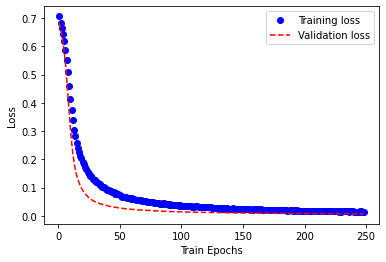

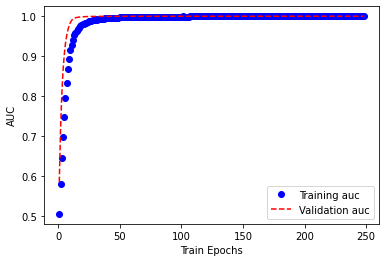

In [6]:
# inspect metrics
history_dict = history.history
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]
auc = history_dict["auc"]
val_auc = history_dict["val_auc"]
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "r--", label="Validation loss")
plt.xlabel("Train Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(epochs, auc, "bo", label="Training auc")
plt.plot(epochs, val_auc, "r--", label="Validation auc")
plt.xlabel("Train Epochs")
plt.ylabel("AUC")
plt.legend()
plt.show()

In [7]:
n = 5
s = 100

p = model.predict(x_val[:1000,:])[:, 0]

scores = eg.get_scores(x_val[:1000,:])
ix_srt = np.argsort(scores)

probs = eg.get_probabilities(x_val[:1000,:])[1]

p = np.convolve(p[ix_srt[::-1]], np.ones(n)/n, mode='valid')
scores = np.convolve(scores[ix_srt[::-1]], np.ones(n)/n, mode='valid')
probs = np.convolve(probs[ix_srt[::-1]], np.ones(n)/n, mode='valid')

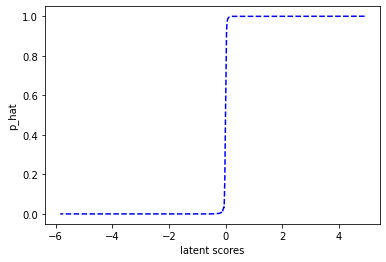

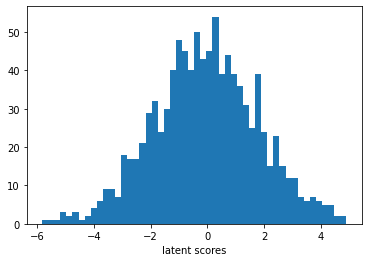

In [8]:
plt.plot(scores, p, '--b')
plt.xlabel('latent scores')
plt.ylabel('p_hat')
plt.show()

plt.hist(scores, bins=50)
plt.xlabel('latent scores')
plt.show()

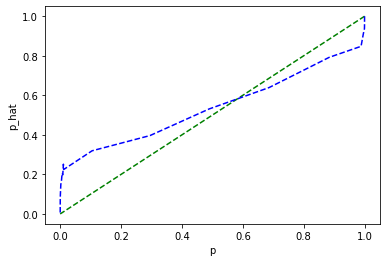

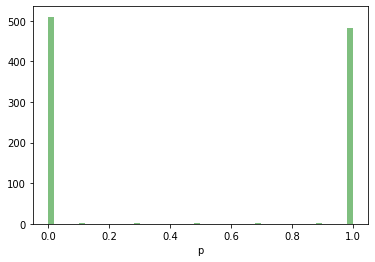

In [9]:
plt.plot(probs, probs, '--g')
plt.plot(probs, p, '--b')
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

plt.hist(probs, bins=50, color='g', alpha=0.5)
plt.xlabel('p')
plt.show()

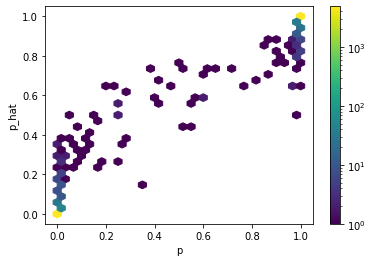

In [10]:
n = 1
s = 100

p = model.predict(x_val[:10000,:])[:, 0]

scores = eg.get_scores(x_val[:10000,:])

probs = eg.get_probabilities(x_val[:10000,:])[1]

plt.hexbin(probs, p, gridsize=30, bins='log')
plt.colorbar()
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

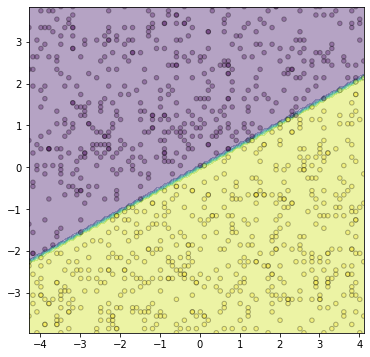

In [11]:
# Plot decision regions
I, J = 2, 6
x_min, x_max = x_val[:, I].min(), x_val[:, I].max()
y_min, y_max = x_val[:, J].min(), x_val[:, J].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
xxyy = np.c_[xx.ravel(), yy.ravel()]
x_ = np.zeros((xxyy.shape[0], 10))
x_[:, I] = xxyy[:, 0]
x_[:, J] = xxyy[:, 1]
z = model.predict(x_)
z = z.reshape(xx.shape)
y_ = eg.get_labels(x_)

fig = plt.figure(figsize=(6,6))
ax = fig.gca()
ax.contourf(xx, yy, z, alpha=0.4)
ixs = np.random.randint(0, y_.shape[0]-1, 1000)
ax.scatter(x_[ixs, I], x_[ixs, J], c=y_[ixs], s=20, alpha=0.3, edgecolor="k")
plt.show()

#model.summary()

In [12]:
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_96 (Dense)            (None, 30)                330       
                                                                 
 dropout_72 (Dropout)        (None, 30)                0         
                                                                 
 dense_97 (Dense)            (None, 30)                930       
                                                                 
 dropout_73 (Dropout)        (None, 30)                0         
                                                                 
 dense_98 (Dense)            (None, 30)                930       
                                                                 
 dropout_74 (Dropout)        (None, 30)                0         
                                                                 
 dense_99 (Dense)            (None, 1)               

In [13]:
champion_params

{'learning_rate': 0.006,
 'batch': 256,
 'epoch': 177,
 'optimizer': 'sgd',
 'best_loss': {'loss': 0.007031420711427927, 'epoch': 248},
 'best_auc': {'auc': 0.9999905824661255, 'epoch': 248},
 'best_accuracy': {'accuracy': 0.9984999895095825, 'epoch': 232},
 'model': <keras.engine.sequential.Sequential at 0x7ff66df766d0>}

In [14]:
scan_results

[{'learning_rate': 2.4e-05,
  'batch': 256,
  'epoch': 84,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.04464928060770035, 'epoch': 119},
  'best_auc': {'auc': 0.999572217464447, 'epoch': 119},
  'best_accuracy': {'accuracy': 0.9886500239372253, 'epoch': 119}},
 {'learning_rate': 3e-05,
  'batch': 256,
  'epoch': 84,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.028316250070929527, 'epoch': 119},
  'best_auc': {'auc': 0.9998289346694946, 'epoch': 119},
  'best_accuracy': {'accuracy': 0.9923999905586243, 'epoch': 119}},
 {'learning_rate': 3.6e-05,
  'batch': 256,
  'epoch': 84,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.01872398890554905, 'epoch': 119},
  'best_auc': {'auc': 0.9999492168426514, 'epoch': 119},
  'best_accuracy': {'accuracy': 0.9959999918937683, 'epoch': 119}},
 {'learning_rate': 0.004,
  'batch': 256,
  'epoch': 177,
  'optimizer': 'sgd',
  'best_loss': {'loss': 0.008835419081151485, 'epoch': 249},
  'best_auc': {'auc': 0.999988317489624, 'epoch': 241},
 

### Tuning notes: 

Data: train 100096 / val 20000

--
* model: 30, 0.25, 30, 0.25, 30, 0.25, 30, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 80/80 **val_loss: 0.4221** - val_accuracy: 0.7657 - val_auc: 0.9857

--
* model: 30, 0.25, 30, 0.25, 30, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 60/80 **val_loss: 0.3241** - val_accuracy: 0.8463 - val_auc: 0.9856

--
* model: 40, 0.25, 40, 0.25, 40, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 40/80 **val_loss: 0.2726** - val_accuracy: 0.8848 - val_auc: 0.9889

--
* model: 50, 0.25, 50, 0.25, 50, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 38/80 **val_loss: 0.2555** - val_accuracy: 0.8832 - val_auc: 0.9916

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 28/80 **val_loss: 0.2552** - val_accuracy: 0.8909 - val_auc: 0.9929

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / Nadam lr: 2e-5
* Epoch: 48/80 **0.2557** - val_accuracy: 0.8771 - val_auc: 0.9935

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 20, 0.25, 6, 0.25, 1/ batch: 256 / Nadam lr: 2e-5
* Epoch: 47/80 **0.3482** - val_accuracy: 0.8346 - val_auc: 0.9910

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / SGD lr: 5e-3
* Epoch: 59/80 **0.2176** - val_accuracy: 0.8953 - val_auc: 0.9961

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / SGD lr: 3e-3
* Epoch: 80/100 **0.2205** - val_accuracy: 0.8970 - val_auc: 0.9951

--
8/1e-2=> 0.2021 - val_accuracy: 0.9207 - val_auc: 0.9904
8/8e-3=> 0.26...
8/1.3e-2=> 0.25